# INTEG 475 Final Project: Biasedness of Useful Votes in Yelp Reviews

|Name        | Student ID|
|------------|-----------|
|Arumoy Shome| 20460621  |
|Shruti Rao  | 20455421  |

## Introduction

![](assets/review.png)

From its humble beginings as an email based referral network for doctors, Yelp has evolved into a billion dollar  publisher of crowd-sourced reviews about local businesses. Within Yelp, the value of a business depends directly on the information provided by users in the form of written reviews and photos. Potential customers can then view these user reviews and make more informed decisions about using a particular service provided by a business.

To make user reviews more reliable for others, Yelp introduced a system of rating these user reviews as well. A user can manually upvote reviews as `useful` to indicate to other users that this piece of text provided meaningful information about a business from their perspective. However, relying on users to manually indicate utility can introduce bias that is unrelated to the actual relevance of the review text. For local businesses and users who are increasingly reliant on such systems over traditional food critiques, the legitimacy of a review can make or break an experience. 

The idea of usefulness is a complicated one, affected by user’s perception and needs. In the case of online reviews, the utility of the text to a user is how well it provides relevant information about the interaction with the business in question. However, because different users have different needs, the value of the supposed relevant information within a review will differ. For a system like Yelp, while user labels of value can provide an additional layer of filtering, it is clear that differences exist in exactly how “usefulness” can be defined between individuals. 

In this project, first a benchmark model is created to predicts a review’s “usefulness” based on review-text. Other models that incorporate other non-review-text related features are then created and compared against the benchmark in order to identify if bias exists when users manually label reviews as “useful”. If bias does exist, knowing the specific features that cause this can be used to better tweak Yelp’s ecosystem to surface unbiased information for users.
    
    
## Research Question
Do users actually read a review before voting it useful or is their influenced by the presence of previsouly registered `cool`, `funny` and `useful` votes.


## Background
There exists a large amount of existing research about online reviews based on the Yelp dataset. The dataset itself is open source and updated with new data annually, encouraging new developments in the review analysis space each year [1]. 

A literature review found that while there are a variety of different techniques [2, 3] being used to analyze review data, random forest classifiers are incredibly popular [4, 5]. One group used Bag-of-Words on review data  combined with features from user and business datasets to predict the required numeric value of the “usefulness” of a review with a batch mode localized weighted regression model. This localized regression approach resulted into RMSLE of 0.47769 [2]. Others compared SVM with logistic regression with Lasso to identify that the latter was the best with lower training error [3]. However, in comparison, using a random forest model with 150 estimators, the square root of original feature numbers to get maximum features, with ten minimum number of leaves to split, and no maximum depth lead to a model accuracy of 0.698926 [4]. Further improvements using random forest prediction with five fold cross validation were able to achieve an accuracy rate of 79% [5].  Another group took this even further and was able to achieve 95% accuracy in correctly labelling a review as useful using this random forest classifier approach [6]. 

In parallel with this research into predicting the “usefulness” of a review is developing an understanding of what skews bias in online reviews. Studies use Amazon and Yelp data to look at what features specific to these two ecosystems cause bias in user perception of review value. Typically, a review is seen relative to other reviews. In a study using over 4 million Amazon book reviews for roughly 675 000 books, the perceived usefulness of reviews was dependent on its relationship to other reviews, not only its content [10]. Information about the reviewer themselves can also affect the perceived utility of a review [8]. Yelp restaurant reviews had their “usefulness” affected by user-based features more than detailed information within the review about the features of the restaurant [9]. More specifically, another group looking at over 72 000 Yelp reviews found that neutral and negative reviews by locals were seen as more useful, even if the information within the review was not necessarily valuable [10].

The novelty of this paper is found in the granular approach to which Yelp dataset-specific features are considered. Instead of a broad generalization of what creates bias, the focus is on features with high correlation with review “usefulness” in order to understand if they bias users.


# Analysis

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

% matplotlib inline

from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC


from scipy.sparse import csr_matrix, csc_matrix, hstack, vstack

**Please note** that we are using a random sample of 10,000 data points from the original dataset which contains over 5 million data points. This was purely because of hardware limitations and to adhere to Learn's upload size limit.

The code that was used to generate this subset can be found under *lib/generate_df_subset.py*

In [42]:
reviews = pd.read_csv('dataset/review.csv', usecols=['text', 'useful', 'cool', 'funny'])

## Data Exploration

In [43]:
reviews.sort_values(by='useful').head()

,funny,text,useful,cool
4999,1,"I really wanted to like this place, but after ...",0,0
3774,0,This is one of my favorite places in Las Vegas...,0,0
3773,0,Amazing service! Catered to my every need from...,0,0
3772,0,Don't let the look of the restaurant dissuade ...,0,0
3771,0,"Great food and great prices, especially for be...",0,0


In [44]:
reviews.describe()

,funny,useful,cool
count,10000.000000,10000.000000,10000.000000
mean,0.520000,1.457000,0.602700
std,1.878285,3.537344,2.218681
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.500000,0.000000
75%,0.000000,2.000000,1.000000
max,61.000000,108.000000,93.000000


In [45]:
# correlations
reviews.corr()

,funny,useful,cool
funny,1.000000,0.660793,0.824521
useful,0.660793,1.000000,0.683033
cool,0.824521,0.683033,1.000000


## Preprocessing and Feature Extraction

We are using the [`TfidfVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) for feature extraction from the `text` column. For this column, a custom `analyzer` method namely `review_process` is written which:
1. removes all punctuations and
3. removes new line characters (escape sequence)

`TfidfVectorizer` class is then set to:
2. remove accents
2. remove all stopwords
3. lowercase all words

For `useful` votes:
2. remove df row if `useful` is `NaN`

In [46]:
reviews.dropna(inplace=True)
print("reviews shape after dropping NaN values: ", reviews.shape)

reviews shape after dropping NaN values:  (10000, 4)


In [47]:
import string
import re

RE_NEWLINE = '\n+'
PUNCTUATIONS = string.punctuation

def review_process(review):
    no_newline = re.sub(RE_NEWLINE, '', review)
    no_punc = ''.join([char for char in no_newline if char not in PUNCTUATIONS])
    
    return no_punc

In [48]:
test = "a str.. with! some @2 punctuations 6546721 and numbers \n [] \n"
print(review_process(test))

a str with some 2 punctuations 6546721 and numbers   


In [49]:
vect = TfidfVectorizer(strip_accents='ascii', preprocessor=review_process, stop_words='english' )
vect

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2',
        preprocessor=<function review_process at 0x14277f400>,
        smooth_idf=True, stop_words='english', strip_accents='ascii',
        sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, use_idf=True, vocabulary=None)

## Generating labels

We assign a label of **1** to reviews that are *useful* and a label of **0** to those which are *not useful*.

In [50]:
import math

NOT_USEFUL = 0
USEFUL = 1

def labeler(vote):
    if math.floor(vote) < THRESHOLD:
        return NOT_USEFUL
    else:
        return USEFUL

In [51]:
reviews['label'] = reviews['useful'].apply(labeler)
    
reviews.head()

,funny,text,useful,cool,label
0,0,"Food was amazing, worth every cent. (although ...",1,0,1
1,0,I would recommend this service to anyone havin...,1,0,1
2,0,A very impressive exhibit showcasing all of Wa...,0,1,0
3,0,My husband and I stopped in here for a light l...,0,0,0
4,0,I attended a service for a 3 1/2 month old bab...,1,1,1


## Cross validation

Cross-validation is an approach that prevents over-fitting and helps generalize our model better.
We will use [K-fold validation](http://scikit-learn.org/stable/modules/cross_validation.html#k-fold) with 5 folds using `cross_val_score` from `sklearn.model_selection` which by default used K-fold validation. `cross_val_score` trains and validates the classifier with *k-1* folds and tests with the remaining fold which means we do not have to create testing and training splits manually.

In [52]:
X = reviews[['text', 'useful', 'cool']]
Y = reviews['label']

In [53]:
def print_percent(flt):
    pretty = "%.2f" % (flt*100)
    
    return "{0}%".format(pretty)

## Instantiate classifiers

We will be using 3 classifiers for this analysis namely, [*Multinomial Naive Bayes*](http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes), [*Linear SVM*](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) and [*Random Forest*](http://scikit-learn.org/stable/modules/ensemble.html#random-forests). These classifiers were choosen as they were the most frequent choices in several papers written on the matter [4, 5, 6, 10].

Please note that the [hyper parameters](http://scikit-learn.org/stable/modules/grid_search.html) of the classifiers were kept at their default values so as to not leak any validation data into the model.

In [54]:
mn_clas = MultinomialNB()
print(mn_clas)
print("\n")

svc_clas = LinearSVC()
print(svc_clas)
print("\n")

rf_clas = RandomForestClassifier()
print(rf_clas)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


## Model 1: Training with `text`

Under this model, only the `text` column is used as the training data and the mean of their scores are printed.

In [55]:
# feature extraction
X1 = vect.fit_transform(X['text'])
print("shape of X1 after feature extraction: ", X1.shape)

shape of X1 after feature extraction:  (10000, 48118)


In [56]:
mn_scores = cross_val_score(mn_clas, X1, Y, cv=5)
svc_scores = cross_val_score(svc_clas, X1, Y, cv=5)
rf_scores = cross_val_score(rf_clas, X1, Y, cv=5)

In [57]:
print("Naive Bayes score: ", print_percent(mn_scores.mean()))
print("Linear SVC score: ", print_percent(svc_scores.mean()))
print("Random Forest score: ", print_percent(rf_scores.mean()))

Naive Bayes score:  59.96%
Linear SVC score:  58.93%
Random Forest score:  59.06%


## Model 2: Training with `text` and `useful` Votes

Since X now contains mixed dtypes, we need to be a bit clever. First, we convert `useful` column for train and test into sparse matrix and *I2* normalize them (I2 is the default for `TfidfVectorizer` so that's what we use here as well).

The rest is straight forward, we create our updated X by stacking the `useful` sparse matrices with X horizontally (such that the number of feature increases). 

In [58]:
useful_sparse_train = normalize(csr_matrix(X['useful']))
print("type of useful_sparse_train: ", type(useful_sparse_train))
print("shape of useful_sparse_train: ", useful_sparse_train.shape)

type of useful_sparse_train:  <class 'scipy.sparse.csr.csr_matrix'>
shape of useful_sparse_train:  (1, 10000)


In [59]:
X2 = hstack([X1, useful_sparse_train.T])
print("shape of X2: ", X2.shape)

shape of X2:  (10000, 48119)


Note that the number of features of X2 has increased by 1 since we are using the `useful` column as a feature for training.

In [60]:
mn_scores = cross_val_score(mn_clas, X2, Y, cv=5)
svc_scores = cross_val_score(svc_clas, X2, Y, cv=5)
rf_scores = cross_val_score(rf_clas, X2, Y, cv=5)

In [61]:
print("Naive Bayes score: ", print_percent(mn_scores.mean()))
print("Linear SVC score: ", print_percent(svc_scores.mean()))
print("Random Forest score: ", print_percent(rf_scores.mean()))

Naive Bayes score:  60.62%
Linear SVC score:  62.89%
Random Forest score:  89.08%


## Model 3: Training with `text` and `cool` Votes

Next we will carry out the analysis with `text` and `cool` votes. We choose `cool` votes since it had the second highest correlation with `useful` (see section: Data Exploration).

In [62]:
cool_sparse_train = normalize(csr_matrix(X['cool']))

In [63]:
X3 = hstack([X1, cool_sparse_train.T])
print("shape of X3: ", X3.shape)

shape of X3:  (10000, 48119)


In [64]:
mn_scores = cross_val_score(mn_clas, X3, Y, cv=5)
svc_scores = cross_val_score(svc_clas, X3, Y, cv=5)
rf_scores = cross_val_score(rf_clas, X3, Y, cv=5)

In [65]:
print("Naive Bayes score: ", print_percent(mn_scores.mean()))
print("Linear SVC score: ", print_percent(svc_scores.mean()))
print("Random Forest score: ", print_percent(rf_scores.mean()))

Naive Bayes score:  60.10%
Linear SVC score:  60.03%
Random Forest score:  65.79%


## Model 4: Training with `text`, `useful` and `cool` Votes

Finally we will carry out the analysis with text, `useful` & `cool` votes.

In [66]:
uc_sparse_train = normalize(csr_matrix(X[['cool', 'useful']]))
print("shape of uc_sparse_train: ", uc_sparse_train.shape)

shape of uc_sparse_train:  (10000, 2)


In [67]:
X4 = hstack([X1, uc_sparse_train])
print("shape of X4: ", X4.shape)

shape of X4:  (10000, 48120)


Note that the features of X4 has increased by 2 since now we have the `useful` and `cool` columns as features for training.

In [68]:
mn_scores = cross_val_score(mn_clas, X4, Y, cv=5)
svc_scores = cross_val_score(svc_clas, X4, Y, cv=5)
rf_scores = cross_val_score(rf_clas, X4, Y, cv=5)

In [69]:
print("Naive Bayes score: ", print_percent(mn_scores.mean()))
print("Linear SVC score: ", print_percent(svc_scores.mean()))
print("Random Forest score: ", print_percent(rf_scores.mean()))

Naive Bayes score:  82.16%
Linear SVC score:  100.00%
Random Forest score:  89.94%


## Summary

The goal of this project was to determine whether `useful` votes received by reviews on Yelp are biased. To understand the presence of any such relationship, we carried out training in four stages:
1. To establish a benchmark, we carried out supervised learning of our model on the text of reviews.
2. Next, the useful votes previously received by reviews are also added during training.
3. For the third model, we trained with review text and `cool` votes which has the highest correlation with `useful` votes.
4. Finally, for the fourth model we trained with text, `useful` and `cool` votes.

**We observed that reviews that obtained a previously high number of `useful` votes were more likely to be voted `useful` in the future.**
Model 1 and Model 3 share similar scores implying that `cool` votes dont cause too much bias towards usefulness of a review.
Finally, Model 4 had the highest scores meaning `useful` and `cool` votes together cause maximum bias.


| Models | Multinomial Naive Bayes| Linear SVM| Random Forest|
|--------|------------------------|-----------|--------------|
| Model 1|59.96%                  |58.93%     |59.47%        |
| Model 2|60.62%                  |62.89%     |85.42%        |
| Model 3|60.10%                  |60.03%     |64.66%        |
| Model 4|82.16%                  |99.99%     |86.61%        |

## Recommendations

1. After feature extraction, [feature selection](http://scikit-learn.org/stable/modules/feature_selection.html) will be helpful once the number of data points increases. Feature selection is a process whereby certain features within the model with low variance are removed. This is useful for us for the following reasons:
    * reduces the training time of our classifiers
    * reduces overfitting by generalizing the model
    * reduces the complexity of the model as there are less features to deal with

2. Improve label generation by using k-means to identify the labels
Presently a Naive methodology has been used to determine the labels for the *useful* votes. A better solution would be to use [k-means](http://scikit-learn.org/stable/modules/clustering.html#k-means) to determine appropriate labels on the *useful* votes through clustering. This is because currently we are assuming that there are only two labels - *useful* and *not useful*; however, the data might indicate the presence of more than two such as *not useful*, *slightly useful*, *useful*, *very useful*, etc.

3. Next, due to hardware limitations, we were only able to work with 10,000 data points. However, based on the [*learning curves*](http://scikit-learn.org/stable/modules/learning_curve.html#learning-curve) generated below for model 4 classifiers, we see that our models prediction rate will improve with increase in data points. 

4. Finally, additional [non-text features](https://www.yelp.ca/dataset/documentation/json) can be included to establish a stronger case for biasedness and pinpoint the specific features causing bias. Examples of such features are:
    * presence of photos in reviews
    * `useful` and `cool` votes given to users themselves for their contributions
    * number of `fans` that the users have
    * attributes of businesses such as `stars` rating and `number of reviews` they recieved

Futhermore, bias due to ethicicty, demography, location, etc. of reviewers should be considered in further analysis.

In [70]:
mn_train_sizes, mn_train_scores, mn_valid_scores = learning_curve(mn_clas, X4, Y, cv=5)
svc_train_sizes, svc_train_scores, svc_valid_scores = learning_curve(svc_clas, X4, Y, cv=5)
rf_train_sizes, rf_train_scores, rf_valid_scores = learning_curve(rf_clas, X4, Y, cv=5)

In [71]:
learning_curve_data = {'Multinomial Bayes': [mn_train_sizes, mn_train_scores, mn_valid_scores],
                       'Linear SVM': [svc_train_sizes, svc_train_scores, svc_valid_scores],
                       'Random Forest': [rf_train_sizes, rf_train_scores, rf_valid_scores]}

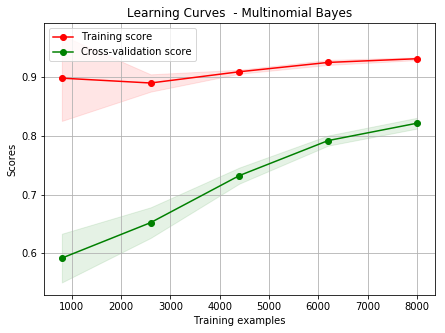

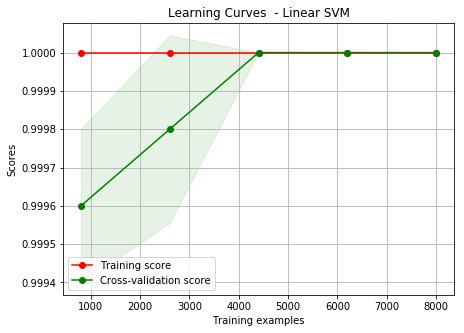

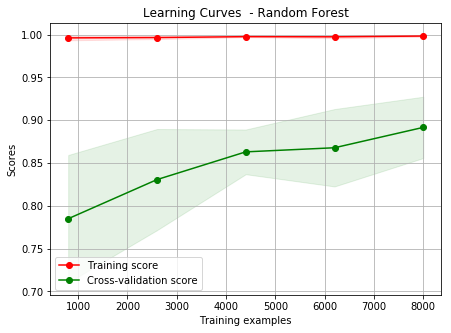

In [72]:
## source: http://scikit-learn.org/stable/auto_examples/model_selection
## /plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py 

for name, data in learning_curve_data.items():
    plt.figure()
    plt.figure(figsize=(7,5))
    plt.title("Learning Curves  - {0}".format(name))

    plt.xlabel("Training examples")
    plt.ylabel("Scores")

    train_scores_mean = np.mean(data[1], axis=1)
    train_scores_std = np.std(data[1], axis=1)

    test_scores_mean = np.mean(data[2], axis=1)
    test_scores_std = np.std(data[2], axis=1)

    plt.grid()

    plt.fill_between(data[0], train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(data[0], test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    plt.plot(data[0], train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(data[0], test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")

## References:

[1] "Yelp Dataset", Yelp, 2018. [Online]. Available: https://www.yelp.ca/dataset/. [Accessed: 09- Apr- 2018].

[2] R. Shen, J. Shen, Y. Li and H. Wang, "Predicting usefulness of Yelp reviews with localized linear regression models", 2016 7th IEEE International Conference on Software Engineering and Service Science (ICSESS), 2016.

[3] X. Liu, M. Schoemaker and N. Zhang, "Predicting Usefulness of Yelp Reviews", Stanford University, Stanford, 2014. http://cs229.stanford.edu/proj2014/Xinyue%20Liu,%20Michel%20Schoemaker,%20Nan%20Zhang,Predicting%20Usefulness%20of%20Yelp%20Reviews.pdf

[4] H. Zhang, X. Li and K. Ying, "Reviews Usefulness Prediction for Yelp Dataset", UC San Diego, San Diego, 2014. https://cseweb.ucsd.edu/classes/wi17/cse258-a/reports/a040.pdf

[5] M. Barakat, "Predicting the Usefulness of a Yelp Review Using Machine Learning", 2018. [Online]. Available: https://rstudio-pubs-static.s3.amazonaws.com/133133_fd7291a46ff547288a25af57b6b35100.html. [Accessed: 07- Apr- 2018].

[6] A. Ghenai, "What makes a review useful, funny or cool on Yelp.com", Project report for CS886: Applied Machine Learning, 2015.

[7] C. Danescu-Niculescu-Mizil, G. Kossinets, J. Kleinberg and L. Lee, "How opinions are received by online communities", Proceedings of the 18th international conference on World wide web - WWW '09, 2009.

[8] P. Racherla and W. Friske, "Perceived ‘usefulness’ of online consumer reviews: An exploratory investigation across three services categories", Electronic Commerce Research and Applications, vol. 11, no. 6, pp. 548-559, 2012.

[9] L. Li, K. Zhang, Q. Zhou and C. Zhang, "Toward Understanding Review Usefulness: A Case Study on Yelp Restaurants", iConference 2016 Proceedings. 2016.

[10] J. Neumann, D. Gutt, D. Kundisch, and D. van Straaten, “When Local Praise Becomes Cheap Talk - Analyzing the Relationship between Reviewer Location and Usefulness of Online Reviews.” Proceedings of the Multikonferenz Wirtschaftsinformatik 2018 (MKWI), Lüneburg, Germany, 2018